# Tagging Task
 **각 단어가 어떤 유형에 속해있는지를 알아내는 태깅 작업**
 
- 개체명 인식 : 어떤 유형인지를 알아내는 것
- 품사 태깅 : 각 단어의 품사가 어떤 것인지를 알아내는 것

**둘 다 RNN의 다대다(Many-to-Many)작업이며, 양방향 RNN을 사용**

## 1) 케라스를 이용한 태깅 작업 개요

- 양방향 LSTM은 Bidirectional안에 LSTM을 넣으면 된다.

### RNN의 다-대-다 문제

-  return_sequences=True를 설정하여 출력층에 모든 은닉 상태값을 보낸다.

## 2) 양방향 LSTM을 이용한 품사 태깅

### 품사 태깅 데이터에 대한 이해와 전처리

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수 : {}".format(len(tagged_sentences)))

품사 태깅이 된 문장 개수 : 3914


In [3]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

#### 단어에 해당하는 부분과 품사 태깅 정보에 해당되는 부분 분리

In [4]:
sentences, pos_tags = [], []

for tagged_sentence in tagged_sentences :
    sentence,tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))

In [6]:
sentences[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [7]:
pos_tags[0]

['NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.']

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722023505365357


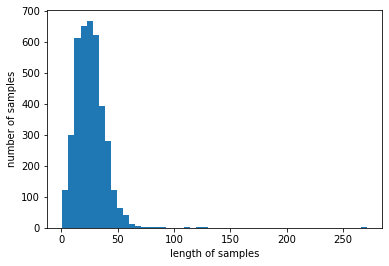

In [9]:
print('샘플의 최대 길이 : {}'.format(max(len(l) for l in sentences)))
print('샘플의 평균 길이 : {}'.format(sum(map(len,sentences)) / len(sentences)))

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [12]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [13]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [14]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [17]:
X_train[0]

[5601,
 3746,
 1,
 2024,
 86,
 331,
 1,
 46,
 2405,
 2,
 131,
 27,
 6,
 2025,
 332,
 459,
 2026,
 3]

In [16]:
y_train[0]

[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9]

In [18]:
max_len = 150
X_train = pad_sequences(X_train,maxlen = max_len,padding = 'post')
y_train = pad_sequences(y_train,maxlen = max_len,padding = 'post')

X_tr,X_test,y_tr,y_test = train_test_split(X_train,y_train,test_size = 0.2, random_state = 777)

In [19]:
y_tr = to_categorical(y_tr, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [21]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3914, 150)
훈련 샘플 레이블의 크기 : (3914, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [23]:
model = Sequential()
model.add(Embedding(vocab_size,128, input_length = max_len, mask_zero = True))
model.add(Bidirectional(LSTM(256,return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size,activation = ('softmax'))))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001),metrics = ['accuracy'])

In [ ]:
model.fit(X_tr, y_tr, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [26]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

In [ ]:
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))